In [50]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import PIL.ExifTags
import PIL.Image
import json
import open3d as o3d
from sklearn.decomposition import PCA
from tqdm import tqdm

In [2]:
with open('camera_model.json', 'r') as f:
    file = json.load(f)
    print(file)

[{'model': 'SONY_ZV1', 'cmos_width': 13.2, 'cmos_height': 8.8}, {'model': 'Canon PowerShot SX740 HS', 'cmos_width': 6.17, 'cmos_height': 4.55}]


In [4]:
img1 = cv.imread("data\small scale\column_left.JPG", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("data\small scale\column_right.JPG", cv.IMREAD_GRAYSCALE)

In [5]:

img = PIL.Image.open('data\IMG_8048.JPG')
exif_data = img._getexif()

exif = {
    PIL.ExifTags.TAGS[k]: v
    for k, v in img._getexif().items()
    if k in PIL.ExifTags.TAGS
}

print("by metadata from image exif, f = {} mm, cx = {} pixels, cy = {} pixels".format(exif['FocalLength'], exif['ExifImageHeight'], exif['ExifImageWidth']))


FileNotFoundError: [Errno 2] No such file or directory: 'data\\IMG_8048.JPG'

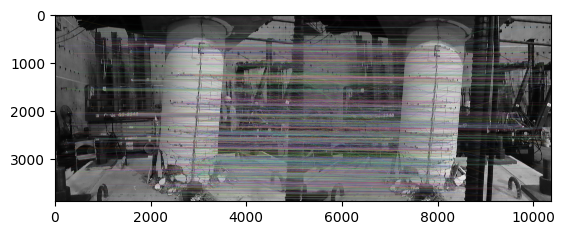

(<matplotlib.image.AxesImage at 0x18400367100>, None)

In [7]:
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
good_matches = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.75*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        good_matches.append([m])
pts1 = np.asarray(pts1)
pts2 = np.asarray(pts2)

img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

In [49]:
camera_intrinsics = np.array([
    [1000, 0, 2500],
    [0, 1000, 2000],
    [0, 0, 1]
])
E, mask = cv.findEssentialMat(pts1, pts2, camera_intrinsics)
_, R, t, mask = cv.recoverPose(E, pts1, pts2, camera_intrinsics)
# obtained R, t, construct P
# [x] x PX = 0
# [x] and P are known
# solve for X
# triangulation


In [128]:
pcd = o3d.io.read_point_cloud("./data/column_metashape.ply")
voxel_size = 0.02
voxel_down_pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
print(voxel_down_pcd)

PointCloud with 880012 points.


In [73]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [129]:
print("Radius oulier removal")
filtered_pcd, ind = voxel_down_pcd.remove_radius_outlier(nb_points=16, radius=0.05)
print(filtered_pcd)
display_inlier_outlier(voxel_down_pcd, ind)

Radius oulier removal
PointCloud with 210848 points.
Showing outliers (red) and inliers (gray): 


In [81]:
o3d.visualization.draw_geometries([filtered_pcd])

In [85]:
def extract_plane_points(pcd, voxel_size):
    pcd.paint_uniform_color([0,1,0])
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    pca = PCA(n_components=3, svd_solver='full')
    linearity_list = []
    planarity_list = []
    eigen_value_list = []
    eigenvector_list = []
    for i in tqdm(np.arange(np.asarray(pcd.points).shape[0])):
        [k, idx, _] = pcd_tree.search_hybrid_vector_3d(pcd.points[i], 3*voxel_size, 30)
        if (k > 3):
            pca.fit(np.asarray(pcd.points)[idx[1:]])
            eigenvalue = (pca.explained_variance_)
            eigenvector = pca.components_

            # extract hand-crafted feature by eigen value
            linearity = (eigenvalue[0] - eigenvalue[1]) / eigenvalue[0]
            planarity = (eigenvalue[1] - eigenvalue[2]) / eigenvalue[0]
            alpha_3d = eigenvalue[2] / eigenvalue[0]
            omnivariance = np.power(eigenvalue[0] * eigenvalue[1] * eigenvalue[2], 1/3)

            assert linearity + planarity + alpha_3d - 1 < 0.001        

        else:
            linearity = 0.33
            planarity = 0.33
            alpha_3d = 0.33

        linearity_list.append(linearity)
        planarity_list.append(planarity)

        eigen_value_list.append(eigenvalue)
        eigenvector_list.append(eigenvector)
    

    plane_points_list = []
    plane_point_v_list = []
    plane_points_ev_list = []

    for i in tqdm(np.arange(len(linearity_list))):
        if (planarity_list[i] > 0.5):
            plane_points_list.append(i)
            plane_point_v_list.append(eigen_value_list[i])
            plane_points_ev_list.append(eigenvector_list[i])
    plane_points_list = np.array(plane_points_list)
    plane_point_v_list = np.array(plane_point_v_list)
    plane_points_ev_list = np.array(plane_points_ev_list)
    return plane_points_list, plane_point_v_list, plane_points_ev_list

def pick_points(pcd):
    print("")
    print(
        "1) Please pick at least three correspondences using [shift + left click]"
    )
    print("   Press [shift + right click] to undo point picking")
    print("2) After picking points, press 'Q' to close the window")
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()  # user picks points
    vis.destroy_window()
    print("")
    return vis.get_picked_points()

In [75]:
plane_points_id_list, plane_points_v_list, plane_points_ev_list = extract_plane_points(filtered_pcd, voxel_size)

100%|██████████| 210848/210848 [00:00<00:00, 2181629.51it/s]


In [130]:
plane_pcd = o3d.geometry.PointCloud()
plane_pcd.points = o3d.utility.Vector3dVector(np.asarray(filtered_pcd.points)[plane_points_id_list])
plane_pcd.colors = o3d.utility.Vector3dVector(np.asarray(filtered_pcd.colors)[plane_points_id_list])
pick_points(plane_pcd)


1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window



[]

In [112]:
def find_similar_ev_points(src_ev: np.ndarray, tgt_points_id: np.ndarray, tgt_evs: np.ndarray):
    '''Given a source point eigen vector, return the point id(s) in target points that have similar first eigenvector
    
    Args:
        src_ev (np.ndarray): source eigen vector
        tgt_points_id (np.ndarray):  target points id(s) from original pcd
        tgt_evs (np.ndarray):    the eigen vectors of target points
    
    Returns:
        np.ndarray: point id(s) that have similar first eigen vector
    '''
    deg_threshold = 10
    C_list = []
    src_ev1 = src_ev[0]

    for index in range(len(tgt_evs)):
        tgt_ev1 = tgt_evs[index][0]
        if (np.abs(np.dot(src_ev1, tgt_ev1)) > np.cos(deg_threshold*np.pi/180)):
            C_list.append(tgt_points_id[index])
    return np.array(C_list)

In [131]:
C_list = find_similar_ev_points(plane_points_ev_list[3243], plane_points_id_list, plane_points_ev_list)
print("number of similar normal = {}".format(len(C_list)))
ground_pcd = o3d.geometry.PointCloud()
ground_pcd.points = o3d.utility.Vector3dVector(np.asarray(filtered_pcd.points)[C_list])
ground_pcd.paint_uniform_color([1,0,0])
o3d.visualization.draw_geometries([ground_pcd])

number of similar normal = 1593


In [141]:
segment_plane = ground_pcd.segment_plane(distance_threshold=0.02, ransac_n=10, num_iterations=100)
params = segment_plane[0]
print("the equation of plane is {:.4f}x + {:.4f}y +{:.4f}z +{:.4f} = 0".format(params[0], params[1], params[2], params[3]))

the equation of plane is -0.0307x + 0.9989y +0.0348z +3.2871 = 0


In [143]:
np.asarray(ground_pcd.colors)[segment_plane[1]] = np.array([0,1,0])
o3d.visualization.draw_geometries([ground_pcd])
# ground done